In [4]:
# default_exp evaluate

# Evaluate module

> a better version of survey. This should allow us to load in a dataframe, do a train-test split, and hen 

In [5]:
#hide
from nbdev.showdoc import *

In [64]:
#export
import openai, pandas as pd, numpy as np, datetime, json, time
from OpenAISurveyWrapper import wrapper

In [44]:
#export
class evaluater(wrapper.wrapper):
    """
    wrapper on the API to load in survey definitions
    a format for displaying
    
    self.myFormat: a function to format a prompt
    """
    labeled = pd.DataFrame()
    raw = pd.DataFrame()
    examples = pd.DataFrame()
    searchTerms = {}
    prompts = {}
    kwargs = {
        "engine":"davinci",
        "temperature":0,
        "max_tokens":10,
        "stop":"\n",
    }
                
    def addPrompt(self, label:str, definition:str):
        """
        set definition of label to definition
        """
        try:
            self.definitions[label]["definition"] = definition
        except:
            self.definitions[label]= {"definition":definition}
        
    def removePrompt(self, label:str):
        """
        set definition of label to definition)
        """
        del self.definitions[label]
        
    def addSearchTerm(self, label:str, searchTerm:str):
        """
        k, this is badly named, but I want to be able to evaluate how search does
        """
        try:
            self.searchTerms[label]["searchTerm"] = searchTerm
        except:
            self.searchTerms[label]= {"searchTerm":searchTerm}
    
    def removeSearchTerm(self, term:str):
        """
        delete search term
        """
        del self.searchTerms[term]
        
    def loadExamplesFromDataFrame(self, examples:dict):
        """
        takes a 2 column dataframe; first column should be "text", second "label"
        """
        if len(examples.columns)!=2:
            raise Exception("need 2 columns, first should be data second label")
        self.examples = examples
        self.examples.columns=["data", "label"]
        
    def generateResponses(self, queries, prompt, maxQuerySize=1500, verbose=False):
        """
        run a prompt against queries.
        prompt should be formated as "str {} str" to be able to use format
        to stick each query in
        """
        results = []
        for query in queries:
            #r = self.query(prompt=prompt.format(query[:maxQuerySize]), verbose=verbose, **self.kwargs)
            if verbose:
                print(r)
            results.append(r)
        return results
        
    def train_test_split(self, trainSize=0, testSize=0):
        """
        generates train and test set
        train sets with openai api can be small; max of 10 fills up the prompt window generally
        """
        if testSize==0:
            print("give it a train and test")
            return -1
        
        working = self.examples.copy()
        
        train = pd.DataFrame()
        test = pd.DataFrame()
        
        for label in working.label.unique():
            newEntries = working[working.label==label]
            newEntries = newEntries.sample(min(len(newEntries), trainSize))
            train = pd.concat([train, newEntries])
            working.drop(newEntries.index, inplace=True)
        self.train = train
        self.test = test

    def optimizeSearchCutoff(self, df, term, trainSize=200, testSize=200):
        """
        run a search against the df texts to get most similar
        the API returns the same similarity scale when the same term is queried multiple times against different docs
        """
        
        
        
    def useTermPrompt(self, n=20, overwrite=True, inplace=True, fewShot = 0, labels=[], verbose=False):
        """
        for each label in labels, add to the 
        """
        if len(labels) == 0:
            labels = [x for x in self.definitions]
        
        if n > 0:
            targets = self.test.sample(n)
        else:
            targets = self.test.copy()
        
        
        all_responses = {}
        for label in labels:
                prompt = self.definitions[label]["prompt"]
                print(prompt)
                responses = self.generateResponses(targets["data"].to_list(), prompt, verbose=verbose)
                
                with open("{}/{}".format(self.outdir, datetime.datetime.now().strftime("%Y%m%d%H%m%S") + ".json"), "w") as fh:
                    json.dump({"prompt":prompt, "data":{"queries":targets["data"].to_list(), "preds":responses}}, fh, indent=4)

                all_responses[label]=responses
                
                targets[label] = responses
                self.labeled = targets
        self.labeled = targets


        

In [51]:
tmp = evaluater()

In [58]:
#hide
df = pd.read_csv("../vice-yikyak-2020-06-09_vice-random-2020-06-23.csv")

In [62]:
#hide
tmp.loadExamplesFromDataFrame(df[["text", "Drinking"]])

# wait, try other

In [176]:
responses = []
trgts = df[:5000]
startIdx = 0
endIdx = 200
while startIdx < len(trgts):
    #responses = responses + trgts[startIdx:endIdx].text.to_list()
    
    responses = responses + openai.Engine("davinci").search(documents=\
                trgts[startIdx:endIdx].text.to_list(), query="drinking and alcohol")["data"]
    startIdx += 200
    endIdx += 200
    time.sleep(2)

In [177]:
trgts["seach_sim"] = [float(x["score"]) for x in responses]

/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [178]:
cutoff_f1 = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1.at["f1", i] = f1_score(trgts.Drinking[:1000], trgts.search_pos[:1000])

/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [179]:
cutoff = cutoff_f1.T.idxmax()[0]
cutoff

145

In [180]:
cutoff_f1_test = pd.DataFrame()
for i in range(100, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1_test.at["f1", i] = f1_score(trgts.Drinking[1000:], trgts.search_pos[1000:])

/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


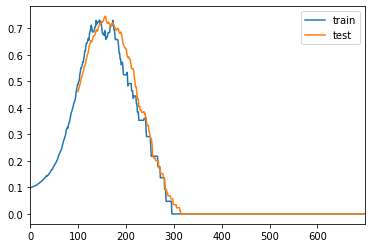

In [181]:
ax = cutoff_f1.T.rename(columns={"f1":"train"}).plot()
cutoff_f1_test.T.rename(columns={"f1":"test"}).plot(ax=ax)

In [182]:
trgts.to_pickle("../drinking and alcohol.pkl")

In [183]:
cutoff_f1_test[cutoff]

f1    0.710183
Name: 145, dtype: float64

In [213]:
trgts = pd.read_pickle("../drinking and alcohol.pkl")

In [215]:
trgts

,Drinking,Tobacco,Vaping,Marijuana,Illegal drugs,Prescription drugs,text,seach_sim,search_pos
0,0,0,0,0,0,0,I'm 20 years old and still can't figure out where my clit is 😒😞,-4.845,0
1,0,0,0,0,0,0,A beard can either make or break you,40.235,0
2,0,0,0,0,0,0,"You know what would get me hard right now, you whippin your dick out! 👬",52.489,0
3,0,0,0,0,0,0,When did the bitch from frozen come to auburn? This is getting a little ridiculous,43.434,0
4,0,0,0,0,0,0,"Do guys find tall girls attractive, like +6foot?",71.722,0
...,...,...,...,...,...,...,...,...,...
4995,0,0,0,0,0,0,"I've become super good friends with my suite, but barely know people outside of that",121.684,0
4996,0,0,0,0,0,0,Instagram quit lackin and fuckin load,74.478,0
4997,0,0,0,0,0,0,"Matlab takes fucking forever to download, so much for bringing my laptop to class",39.025,0
4998,0,0,0,1,0,0,Don't read yik yak when you're high. You'll take each sentence literally and consider each word seriously,98.645,0


In [216]:
cutoff_f1 = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1.at["f1", i] = f1_score(trgts.Drinking[:1000], trgts.search_pos[:1000])

cutoff = cutoff_f1.T.idxmax()[0]


cutoff_f1_test = pd.DataFrame()
for i in range(100, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1_test.at["f1", i] = f1_score(trgts.Drinking[1000:], trgts.search_pos[1000:])



trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > cutoff else 0)
ddd = trgts[1000:]
ddd[ddd["search_pos"] != ddd["Drinking"]]



,Drinking,Tobacco,Vaping,Marijuana,Illegal drugs,Prescription drugs,text,seach_sim,search_pos
1028,0,0,0,0,0,0,I do t understand how people drink unsweet tea,188.243,1
1043,0,0,0,0,0,0,"I am in a sorority, I think I'm fun to be around but I seriously have no friends. I'm thinking about ending it",154.458,1
1100,0,0,0,0,0,0,"So it's my 21st today, and shit it's like the fucking universe aligned that it's a Friday and tomorrow is waste management and Sunday is the super bowl.",156.103,1
1198,1,0,0,0,0,0,These teachers need to learn to teach in the dark. Wayyyyyy too hungover for these bright lights.,143.536,0
1200,0,0,0,0,0,0,"I've never been to a frat party before. Do you have to know someone in the fraternity, or do you just show up and look attractive?",160.826,1
...,...,...,...,...,...,...,...,...,...
4904,0,0,0,0,0,0,Mimosas... That is all,163.003,1
4930,0,0,0,0,0,0,U of A students #YOLO with wine coolers.,189.143,1
4971,0,0,0,0,0,0,"When your friend asks if you had a rough night, nope I'm just ugly lol",150.042,1
4980,0,0,0,0,0,0,My girlfriend and I had unprotected sex a couple weeks ago. Her period was supposed to come 3 days ago.... #help,187.210,1


In [184]:
trgts = df[:5000]

In [185]:
betterTrain = df[5000:]
betterTrainAlcohol = betterTrain[betterTrain.Drinking==1][:100]
betterTrainNoAlcohol = betterTrain[betterTrain.Drinking!=1][:100]

In [187]:
newtrgts = pd.concat([betterTrainAlcohol, betterTrainNoAlcohol, trgts[200:]])

In [190]:
trgts = newtrgts.reset_index(drop=True)

In [191]:
responses = []
startIdx = 0
endIdx = 200

while startIdx < len(trgts):
    #responses = responses + trgts[startIdx:endIdx].text.to_list()
    
    responses = responses + openai.Engine("davinci").search(documents=\
                trgts[startIdx:endIdx].text.to_list(), query="drinking and alcohol")["data"]
    startIdx += 200
    endIdx += 200


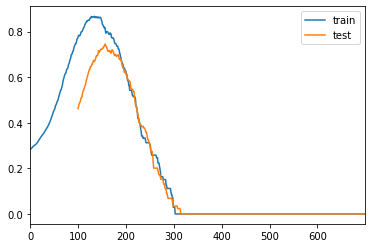

In [192]:
trgts["seach_sim"] = [float(x["score"]) for x in responses]

cutoff_f1 = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1.at["f1", i] = f1_score(trgts.Drinking[:1000], trgts.search_pos[:1000])

cutoff = cutoff_f1.T.idxmax()[0]


cutoff_f1_test = pd.DataFrame()
for i in range(100, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1_test.at["f1", i] = f1_score(trgts.Drinking[1000:], trgts.search_pos[1000:])

ax = cutoff_f1.T.rename(columns={"f1":"train"}).plot()
cutoff_f1_test.T.rename(columns={"f1":"test"}).plot(ax=ax)

In [193]:
trgts.to_pickle("../drinking and alcohol_smartstart.pkl")

In [198]:
trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > cutoff else 0)

In [194]:
cutoff_f1_test[cutoff]

f1    0.668235
Name: 134, dtype: float64

In [200]:
pd.set_option('display.max_colwidth', -1)


In [201]:
trgts[trgts["search_pos"] != trgts["Drinking"]]

,Drinking,Tobacco,Vaping,Marijuana,Illegal drugs,Prescription drugs,text,seach_sim,search_pos
1,1,0,0,0,0,0,Little Italy drunchies tho,104.135,0
10,1,0,0,0,0,0,"Starting off the New Year with money from working the NYE Tempe Block party, no hangover and the gym this afternoon. You better believe I'm doing 2015 right!",102.506,0
17,1,0,0,0,0,0,Where are the babes that just wanna drink whiskey and come over to my place to play Mario Kart?,102.380,0
21,1,0,0,0,0,0,"Hey Chem 102 students: I know we just met and you're hoping to learn shit, but I'm very drunk and won't want to get up tomorrow, so please just stay home. Love, your TA",113.618,0
42,1,0,0,0,0,0,Already realizing how tough this semester is going to be without my best friend. I need a new right hand lady. Accepting applications now Netflix and wine are a plus,117.300,0
...,...,...,...,...,...,...,...,...,...
4930,0,0,0,0,0,0,U of A students #YOLO with wine coolers.,189.428,1
4971,0,0,0,0,0,0,"When your friend asks if you had a rough night, nope I'm just ugly lol",150.255,1
4980,0,0,0,0,0,0,My girlfriend and I had unprotected sex a couple weeks ago. Her period was supposed to come 3 days ago.... #help,187.210,1
4981,0,0,0,0,0,0,Party at regents. Girls invited,136.849,1


# TRY OR

/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyd

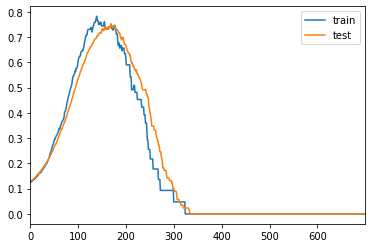

In [202]:
responses = []
trgts = df[:5000]
startIdx = 0
endIdx = 200
while startIdx < len(trgts):
    #responses = responses + trgts[startIdx:endIdx].text.to_list()
    
    responses = responses + openai.Engine("davinci").search(documents=\
                trgts[startIdx:endIdx].text.to_list(), query="drunk or drinking")["data"]
    startIdx += 200
    endIdx += 200
    time.sleep(2)

trgts["seach_sim"] = [float(x["score"]) for x in responses]

cutoff_f1 = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1.at["f1", i] = f1_score(trgts.Drinking[:1000], trgts.search_pos[:1000])

cutoff = cutoff_f1.T.idxmax()[0]
cutoff

cutoff_f1_test = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1_test.at["f1", i] = f1_score(trgts.Drinking[1000:], trgts.search_pos[1000:])

ax = cutoff_f1.T.rename(columns={"f1":"train"}).plot()
cutoff_f1_test.T.rename(columns={"f1":"test"}).plot(ax=ax)

In [203]:
trgts.to_pickle("../drunk or drinking.pkl")

In [204]:
cutoff_f1_test[cutoff]

f1    0.702439
Name: 139, dtype: float64

In [205]:
trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > cutoff else 0)
trgts[trgts["search_pos"] != trgts["Drinking"]]

/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Drinking,Tobacco,Vaping,Marijuana,Illegal drugs,Prescription drugs,text,seach_sim,search_pos
18,0,0,0,0,0,0,Are we allowed to call DART to get us home after leg day?,175.699,1
20,1,0,0,0,0,0,Everyone was getting turnt up and crazy while I was at home with an old high school friend watching The Incredibles. Now that was a fun New Years Eve ^_^,27.021,0
44,0,0,0,0,0,0,Hangover 1 is still funny af,192.883,1
243,0,0,0,0,0,0,Anybody in sassnet wanna pregame?,215.994,1
260,0,0,0,0,0,0,Fireworks on campus or what...,154.330,1
...,...,...,...,...,...,...,...,...,...
4904,0,0,0,0,0,0,Mimosas... That is all,168.530,1
4930,0,0,0,0,0,0,U of A students #YOLO with wine coolers.,154.361,1
4980,0,0,0,0,0,0,My girlfriend and I had unprotected sex a couple weeks ago. Her period was supposed to come 3 days ago.... #help,170.715,1
4981,0,0,0,0,0,0,Party at regents. Girls invited,182.094,1


In [206]:
# Wine, beer, or liquor

/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyd

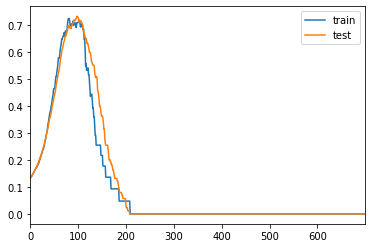

In [207]:
responses = []
trgts = df[:5000]
startIdx = 0
endIdx = 200
while startIdx < len(trgts):
    #responses = responses + trgts[startIdx:endIdx].text.to_list()
    
    responses = responses + openai.Engine("davinci").search(documents=\
                trgts[startIdx:endIdx].text.to_list(), query="wine or beer or liquor")["data"]
    startIdx += 200
    endIdx += 200
    time.sleep(2)

trgts["seach_sim"] = [float(x["score"]) for x in responses]

cutoff_f1 = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1.at["f1", i] = f1_score(trgts.Drinking[:1000], trgts.search_pos[:1000])

cutoff = cutoff_f1.T.idxmax()[0]
cutoff

cutoff_f1_test = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1_test.at["f1", i] = f1_score(trgts.Drinking[1000:], trgts.search_pos[1000:])

ax = cutoff_f1.T.rename(columns={"f1":"train"}).plot()
cutoff_f1_test.T.rename(columns={"f1":"test"}).plot(ax=ax)

trgts.to_pickle("../wine or beer or liquor.pkl")

In [208]:
cutoff_f1_test[cutoff]

f1    0.699229
Name: 80, dtype: float64

In [209]:
trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > cutoff else 0)
trgts[trgts["search_pos"] != trgts["Drinking"]]

/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Drinking,Tobacco,Vaping,Marijuana,Illegal drugs,Prescription drugs,text,seach_sim,search_pos
20,1,0,0,0,0,0,Everyone was getting turnt up and crazy while I was at home with an old high school friend watching The Incredibles. Now that was a fun New Years Eve ^_^,2.436,0
44,0,0,0,0,0,0,Hangover 1 is still funny af,91.131,1
98,1,0,0,0,0,0,"Motto to live by: lift heavy, drink heavy, study hard, fuck hard",75.510,0
122,0,0,0,0,0,1,whose got the xanax,115.351,1
135,1,0,0,0,0,0,"Saturday night, syllabus week. Blackout or blackout Devils. Turn up and get home safely yall.",49.950,0
...,...,...,...,...,...,...,...,...,...
4851,0,0,0,0,0,0,"If you've dated a redhead, raise your glasses. If not, raise your standards.",86.292,1
4904,0,0,0,0,0,0,Mimosas... That is all,138.967,1
4930,0,0,0,0,0,0,U of A students #YOLO with wine coolers.,83.420,1
4976,0,0,0,1,0,0,Jesus i just want weed is that too much to ask,97.679,1


# Drinking Wine and Alcohol

/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyd

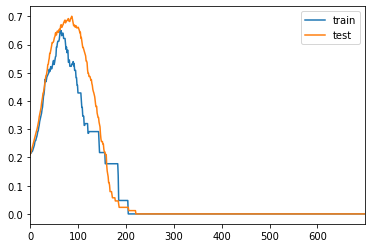

In [210]:
responses = []
trgts = df[:5000]
startIdx = 0
endIdx = 200
while startIdx < len(trgts):
    #responses = responses + trgts[startIdx:endIdx].text.to_list()
    
    responses = responses + openai.Engine("davinci").search(documents=\
                trgts[startIdx:endIdx].text.to_list(), query="drinking wine and alcohol")["data"]
    startIdx += 200
    endIdx += 200
    time.sleep(2)

trgts["seach_sim"] = [float(x["score"]) for x in responses]

cutoff_f1 = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1.at["f1", i] = f1_score(trgts.Drinking[:1000], trgts.search_pos[:1000])

cutoff = cutoff_f1.T.idxmax()[0]
cutoff

cutoff_f1_test = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1_test.at["f1", i] = f1_score(trgts.Drinking[1000:], trgts.search_pos[1000:])

ax = cutoff_f1.T.rename(columns={"f1":"train"}).plot()
cutoff_f1_test.T.rename(columns={"f1":"test"}).plot(ax=ax)

trgts.to_pickle("../drinking wine and alcohol.pkl")

In [211]:
cutoff_f1_test[cutoff]

f1    0.655827
Name: 63, dtype: float64

In [212]:
trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > cutoff else 0)
trgts[trgts["search_pos"] != trgts["Drinking"]]

/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Drinking,Tobacco,Vaping,Marijuana,Illegal drugs,Prescription drugs,text,seach_sim,search_pos
20,1,0,0,0,0,0,Everyone was getting turnt up and crazy while I was at home with an old high school friend watching The Incredibles. Now that was a fun New Years Eve ^_^,1.752,0
44,0,0,0,0,0,0,Hangover 1 is still funny af,90.827,1
135,1,0,0,0,0,0,"Saturday night, syllabus week. Blackout or blackout Devils. Turn up and get home safely yall.",31.090,0
208,1,0,0,0,0,0,Anyone wanna grab a few beers at bdubs and watch the dallas/detroit game?,16.275,0
243,0,0,0,0,0,0,Anybody in sassnet wanna pregame?,122.647,1
...,...,...,...,...,...,...,...,...,...
4904,0,0,0,0,0,0,Mimosas... That is all,104.956,1
4930,0,0,0,0,0,0,U of A students #YOLO with wine coolers.,83.374,1
4976,0,0,0,1,0,0,Jesus i just want weed is that too much to ask,73.605,1
4980,0,0,0,0,0,0,My girlfriend and I had unprotected sex a couple weeks ago. Her period was supposed to come 3 days ago.... #help,97.001,1


# Wine or beer

/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyd

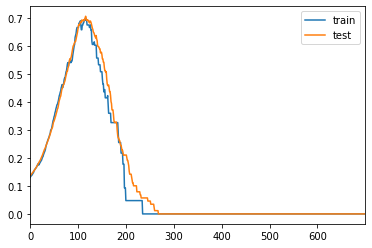

In [217]:
responses = []
trgts = df[:5000]
startIdx = 0
endIdx = 200
while startIdx < len(trgts):
    #responses = responses + trgts[startIdx:endIdx].text.to_list()
    
    responses = responses + openai.Engine("davinci").search(documents=\
                trgts[startIdx:endIdx].text.to_list(), query="wine or beer")["data"]
    startIdx += 200
    endIdx += 200
    time.sleep(2)

trgts["seach_sim"] = [float(x["score"]) for x in responses]

cutoff_f1 = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1.at["f1", i] = f1_score(trgts.Drinking[:1000], trgts.search_pos[:1000])

cutoff = cutoff_f1.T.idxmax()[0]
cutoff

cutoff_f1_test = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1_test.at["f1", i] = f1_score(trgts.Drinking[1000:], trgts.search_pos[1000:])

ax = cutoff_f1.T.rename(columns={"f1":"train"}).plot()
cutoff_f1_test.T.rename(columns={"f1":"test"}).plot(ax=ax)

trgts.to_pickle("../wine or beer.pkl")

# wine beer

/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyd

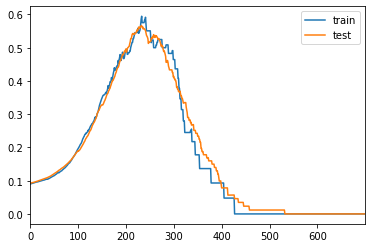

In [219]:
responses = []
trgts = df[:5000]
startIdx = 0
endIdx = 200
while startIdx < len(trgts):
    #responses = responses + trgts[startIdx:endIdx].text.to_list()
    
    responses = responses + openai.Engine("davinci").search(documents=\
                trgts[startIdx:endIdx].text.to_list(), query="wine beer")["data"]
    startIdx += 200
    endIdx += 200
    time.sleep(2)

trgts["seach_sim"] = [float(x["score"]) for x in responses]

cutoff_f1 = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1.at["f1", i] = f1_score(trgts.Drinking[:1000], trgts.search_pos[:1000])

cutoff = cutoff_f1.T.idxmax()[0]
cutoff

cutoff_f1_test = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1_test.at["f1", i] = f1_score(trgts.Drinking[1000:], trgts.search_pos[1000:])

ax = cutoff_f1.T.rename(columns={"f1":"train"}).plot()
cutoff_f1_test.T.rename(columns={"f1":"test"}).plot(ax=ax)

trgts.to_pickle("../wine beer.pkl")

/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyd

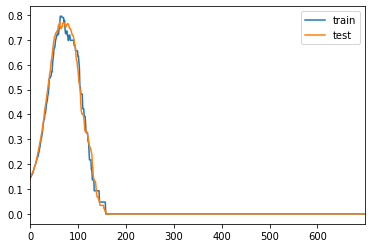

In [220]:
responses = []
trgts = df[:5000]
startIdx = 0
endIdx = 200
while startIdx < len(trgts):
    #responses = responses + trgts[startIdx:endIdx].text.to_list()
    
    responses = responses + openai.Engine("davinci").search(documents=\
                trgts[startIdx:endIdx].text.to_list(), query="wine or beer or alcohol or drunk")["data"]
    startIdx += 200
    endIdx += 200
    time.sleep(2)

trgts["seach_sim"] = [float(x["score"]) for x in responses]

cutoff_f1 = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1.at["f1", i] = f1_score(trgts.Drinking[:1000], trgts.search_pos[:1000])

cutoff = cutoff_f1.T.idxmax()[0]
cutoff

cutoff_f1_test = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1_test.at["f1", i] = f1_score(trgts.Drinking[1000:], trgts.search_pos[1000:])

ax = cutoff_f1.T.rename(columns={"f1":"train"}).plot()
cutoff_f1_test.T.rename(columns={"f1":"test"}).plot(ax=ax)

trgts.to_pickle("../wine or beer or alcohol or drunk.pkl")


In [222]:
cutoff_f1_test[cutoff]


f1    0.74928
Name: 63, dtype: float64

In [221]:

trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > cutoff else 0)
trgts[trgts["search_pos"] != trgts["Drinking"]]

/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Drinking,Tobacco,Vaping,Marijuana,Illegal drugs,Prescription drugs,text,seach_sim,search_pos
20,1,0,0,0,0,0,Everyone was getting turnt up and crazy while I was at home with an old high school friend watching The Incredibles. Now that was a fun New Years Eve ^_^,23.584,0
44,0,0,0,0,0,0,Hangover 1 is still funny af,80.846,1
98,1,0,0,0,0,0,"Motto to live by: lift heavy, drink heavy, study hard, fuck hard",16.911,0
122,0,0,0,0,0,1,whose got the xanax,66.109,1
135,1,0,0,0,0,0,"Saturday night, syllabus week. Blackout or blackout Devils. Turn up and get home safely yall.",13.851,0
...,...,...,...,...,...,...,...,...,...
4627,0,0,0,0,0,0,"Classes start tomorrow and i dont have enough money to buy my books..... Well, time to drink the sad away",108.103,1
4827,1,0,0,0,0,0,Turn 21 today! I'm one Turnt Devil,16.343,0
4904,0,0,0,0,0,0,Mimosas... That is all,84.335,1
4915,0,0,0,1,0,0,My mom just texted me saying she's proud of me. I'm high rn and now i feel guilty about it now,65.694,1


# asdf

/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyd

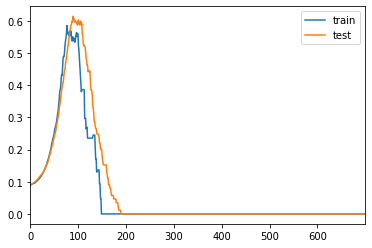

In [223]:
responses = []
trgts = df[:5000]
startIdx = 0
endIdx = 200
while startIdx < len(trgts):
    #responses = responses + trgts[startIdx:endIdx].text.to_list()
    
    responses = responses + openai.Engine("davinci").search(documents=\
                trgts[startIdx:endIdx].text.to_list(), query="drinking buying or recovering from alcohol")["data"]
    startIdx += 200
    endIdx += 200
    time.sleep(2)

trgts["seach_sim"] = [float(x["score"]) for x in responses]

cutoff_f1 = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1.at["f1", i] = f1_score(trgts.Drinking[:1000], trgts.search_pos[:1000])

cutoff = cutoff_f1.T.idxmax()[0]
cutoff

cutoff_f1_test = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1_test.at["f1", i] = f1_score(trgts.Drinking[1000:], trgts.search_pos[1000:])

ax = cutoff_f1.T.rename(columns={"f1":"train"}).plot()
cutoff_f1_test.T.rename(columns={"f1":"test"}).plot(ax=ax)

trgts.to_pickle("../drinking buying or recovering from alcohol.pkl")


In [224]:
cutoff_f1_test[cutoff]


f1    0.498099
Name: 77, dtype: float64

/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyd

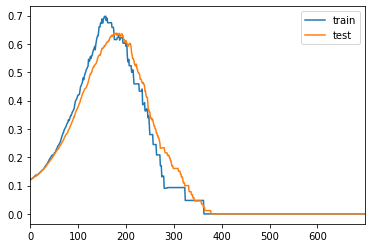

In [225]:
responses = []
trgts = df[:5000]
startIdx = 0
endIdx = 200
while startIdx < len(trgts):
    #responses = responses + trgts[startIdx:endIdx].text.to_list()
    
    responses = responses + openai.Engine("davinci").search(documents=\
                trgts[startIdx:endIdx].text.to_list(), query="alcoholic beverages")["data"]
    startIdx += 200
    endIdx += 200
    time.sleep(2)

trgts["seach_sim"] = [float(x["score"]) for x in responses]

cutoff_f1 = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1.at["f1", i] = f1_score(trgts.Drinking[:1000], trgts.search_pos[:1000])

cutoff = cutoff_f1.T.idxmax()[0]
cutoff

cutoff_f1_test = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1_test.at["f1", i] = f1_score(trgts.Drinking[1000:], trgts.search_pos[1000:])

ax = cutoff_f1.T.rename(columns={"f1":"train"}).plot()
cutoff_f1_test.T.rename(columns={"f1":"test"}).plot(ax=ax)

trgts.to_pickle("../alcoholic beverages.pkl")


In [226]:
cutoff_f1_test[cutoff]


f1    0.593458
Name: 157, dtype: float64

/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyd

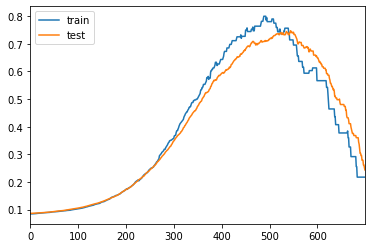

In [227]:
responses = []
trgts = df[:5000]
startIdx = 0
endIdx = 200
while startIdx < len(trgts):
    #responses = responses + trgts[startIdx:endIdx].text.to_list()
    
    responses = responses + openai.Engine("davinci").search(documents=\
                trgts[startIdx:endIdx].text.to_list(), query="booze")["data"]
    startIdx += 200
    endIdx += 200
    time.sleep(2)

trgts["seach_sim"] = [float(x["score"]) for x in responses]

cutoff_f1 = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1.at["f1", i] = f1_score(trgts.Drinking[:1000], trgts.search_pos[:1000])

cutoff = cutoff_f1.T.idxmax()[0]
cutoff

cutoff_f1_test = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1_test.at["f1", i] = f1_score(trgts.Drinking[1000:], trgts.search_pos[1000:])

ax = cutoff_f1.T.rename(columns={"f1":"train"}).plot()
cutoff_f1_test.T.rename(columns={"f1":"test"}).plot(ax=ax)

trgts.to_pickle("../booze.pkl")


In [256]:
trgts = pd.read_pickle("../booze.pkl")


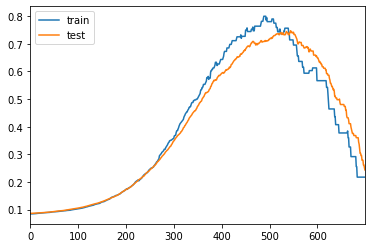

In [257]:
cutoff_f1 = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1.at["f1", i] = f1_score(trgts.Drinking[:1000], trgts.search_pos[:1000])

cutoff = cutoff_f1.T.idxmax()[0]
cutoff

cutoff_f1_test = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1_test.at["f1", i] = f1_score(trgts.Drinking[1000:], trgts.search_pos[1000:])



Text(0.5, 0, 'search cutoff score')

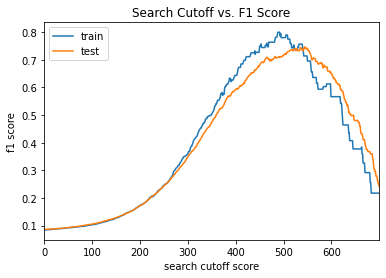

In [261]:
ax = cutoff_f1.T.rename(columns={"f1":"train"}).plot()
cutoff_f1_test.T.rename(columns={"f1":"test"}).plot(ax=ax)
ax.set_title("Search Cutoff vs. F1 Score")
ax.set_ylabel("f1 score")
ax.set_xlabel("search cutoff score")

In [228]:
cutoff_f1_test[cutoff]


f1    0.708447
Name: 488, dtype: float64

/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyd

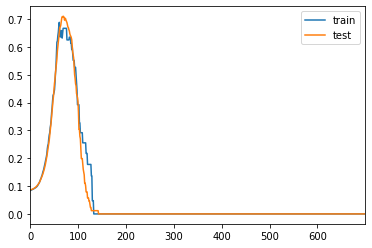

In [229]:
responses = []
trgts = df[:5000]
startIdx = 0
endIdx = 200
while startIdx < len(trgts):
    #responses = responses + trgts[startIdx:endIdx].text.to_list()
    
    responses = responses + openai.Engine("davinci").search(documents=\
                trgts[startIdx:endIdx].text.to_list(), query="wine or beer whiskey or alcohol or drunk or hungover")["data"]
    startIdx += 200
    endIdx += 200
    time.sleep(2)

trgts["seach_sim"] = [float(x["score"]) for x in responses]

cutoff_f1 = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1.at["f1", i] = f1_score(trgts.Drinking[:1000], trgts.search_pos[:1000])

cutoff = cutoff_f1.T.idxmax()[0]
cutoff

cutoff_f1_test = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1_test.at["f1", i] = f1_score(trgts.Drinking[1000:], trgts.search_pos[1000:])

ax = cutoff_f1.T.rename(columns={"f1":"train"}).plot()
cutoff_f1_test.T.rename(columns={"f1":"test"}).plot(ax=ax)

trgts.to_pickle("../wine or beer whiskey or alcohol or drunk or hungover.pkl")


In [230]:
cutoff_f1_test[cutoff]


f1    0.653938
Name: 61, dtype: float64

/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyd

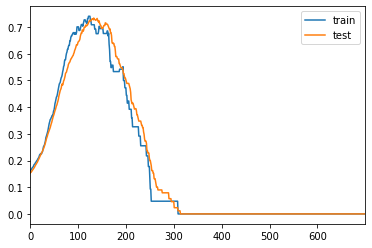

In [231]:
responses = []
trgts = df[:5000]
startIdx = 0
endIdx = 200
while startIdx < len(trgts):
    #responses = responses + trgts[startIdx:endIdx].text.to_list()
    
    responses = responses + openai.Engine("davinci").search(documents=\
                trgts[startIdx:endIdx].text.to_list(), query="booze or drunk")["data"]
    startIdx += 200
    endIdx += 200
    time.sleep(2)

trgts["seach_sim"] = [float(x["score"]) for x in responses]

cutoff_f1 = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1.at["f1", i] = f1_score(trgts.Drinking[:1000], trgts.search_pos[:1000])

cutoff = cutoff_f1.T.idxmax()[0]
cutoff

cutoff_f1_test = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1_test.at["f1", i] = f1_score(trgts.Drinking[1000:], trgts.search_pos[1000:])

ax = cutoff_f1.T.rename(columns={"f1":"train"}).plot()
cutoff_f1_test.T.rename(columns={"f1":"test"}).plot(ax=ax)

trgts.to_pickle("../booze or drunk.pkl")


In [232]:
cutoff_f1_test[cutoff]


f1    0.716332
Name: 122, dtype: float64

/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyd

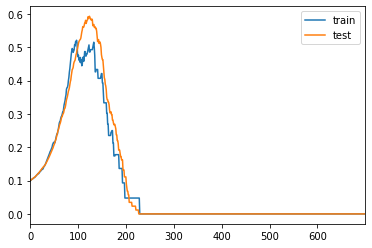

In [233]:
responses = []
trgts = df[:5000]
startIdx = 0
endIdx = 200
while startIdx < len(trgts):
    #responses = responses + trgts[startIdx:endIdx].text.to_list()
    
    responses = responses + openai.Engine("davinci").search(documents=\
                trgts[startIdx:endIdx].text.to_list(), query="booze beer or wine")["data"]
    startIdx += 200
    endIdx += 200
    time.sleep(2)

trgts["seach_sim"] = [float(x["score"]) for x in responses]

cutoff_f1 = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1.at["f1", i] = f1_score(trgts.Drinking[:1000], trgts.search_pos[:1000])

cutoff = cutoff_f1.T.idxmax()[0]
cutoff

cutoff_f1_test = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1_test.at["f1", i] = f1_score(trgts.Drinking[1000:], trgts.search_pos[1000:])

ax = cutoff_f1.T.rename(columns={"f1":"train"}).plot()
cutoff_f1_test.T.rename(columns={"f1":"test"}).plot(ax=ax)

trgts.to_pickle("../booze beer or wine.pkl")


In [234]:
cutoff_f1_test[cutoff]


f1    0.48249
Name: 97, dtype: float64

/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyd

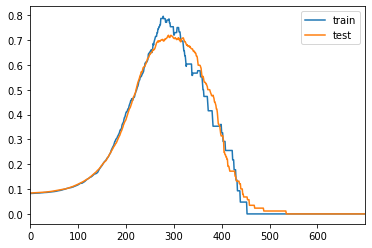

In [235]:
responses = []
trgts = df[:5000]
startIdx = 0
endIdx = 200
while startIdx < len(trgts):
    #responses = responses + trgts[startIdx:endIdx].text.to_list()
    
    responses = responses + openai.Engine("davinci").search(documents=\
                trgts[startIdx:endIdx].text.to_list(), query="drinking booze")["data"]
    startIdx += 200
    endIdx += 200
    time.sleep(2)

trgts["seach_sim"] = [float(x["score"]) for x in responses]

cutoff_f1 = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1.at["f1", i] = f1_score(trgts.Drinking[:1000], trgts.search_pos[:1000])

cutoff = cutoff_f1.T.idxmax()[0]
cutoff

cutoff_f1_test = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1_test.at["f1", i] = f1_score(trgts.Drinking[1000:], trgts.search_pos[1000:])

ax = cutoff_f1.T.rename(columns={"f1":"train"}).plot()
cutoff_f1_test.T.rename(columns={"f1":"test"}).plot(ax=ax)

trgts.to_pickle("../drinking booze.pkl")


In [236]:
cutoff_f1_test[cutoff]


f1    0.697051
Name: 278, dtype: float64

/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyd

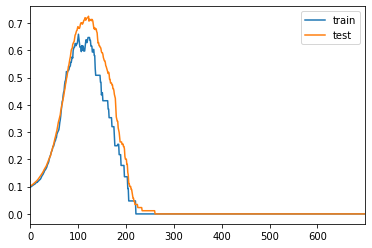

In [237]:
responses = []
trgts = df[:5000]
startIdx = 0
endIdx = 200
while startIdx < len(trgts):
    #responses = responses + trgts[startIdx:endIdx].text.to_list()
    
    responses = responses + openai.Engine("davinci").search(documents=\
                trgts[startIdx:endIdx].text.to_list(), query="drinking wine or booze")["data"]
    startIdx += 200
    endIdx += 200
    time.sleep(2)

trgts["seach_sim"] = [float(x["score"]) for x in responses]

cutoff_f1 = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1.at["f1", i] = f1_score(trgts.Drinking[:1000], trgts.search_pos[:1000])

cutoff = cutoff_f1.T.idxmax()[0]
cutoff

cutoff_f1_test = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1_test.at["f1", i] = f1_score(trgts.Drinking[1000:], trgts.search_pos[1000:])

ax = cutoff_f1.T.rename(columns={"f1":"train"}).plot()
cutoff_f1_test.T.rename(columns={"f1":"test"}).plot(ax=ax)

trgts.to_pickle("../drinking wine or booze.pkl")


In [238]:
cutoff_f1_test[cutoff]


f1    0.681934
Name: 101, dtype: float64

In [239]:
df.head()

,Drinking,Tobacco,Vaping,Marijuana,Illegal drugs,Prescription drugs,text
0,0,0,0,0,0,0,I'm 20 years old and still can't figure out where my clit is 😒😞
1,0,0,0,0,0,0,A beard can either make or break you
2,0,0,0,0,0,0,"You know what would get me hard right now, you whippin your dick out! 👬"
3,0,0,0,0,0,0,When did the bitch from frozen come to auburn? This is getting a little ridiculous
4,0,0,0,0,0,0,"Do guys find tall girls attractive, like +6foot?"


/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata

ValueError: Single '}' encountered in format string

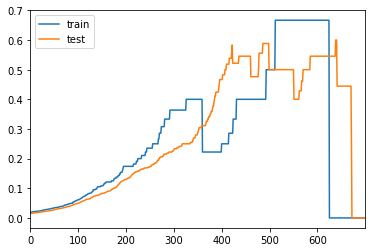

In [241]:
responses = []
trgts = df[:5000]
startIdx = 0
endIdx = 200

query = "Tobacco"

while startIdx < len(trgts):
    #responses = responses + trgts[startIdx:endIdx].text.to_list()
    
    responses = responses + openai.Engine("davinci").search(documents=\
                trgts[startIdx:endIdx].text.to_list(), query=query)["data"]
    startIdx += 200
    endIdx += 200
    time.sleep(2)

trgts["seach_sim"] = [float(x["score"]) for x in responses]

cutoff_f1 = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1.at["f1", i] = f1_score(trgts.Tobacco[:1000], trgts.search_pos[:1000])

cutoff = cutoff_f1.T.idxmax()[0]
cutoff

cutoff_f1_test = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1_test.at["f1", i] = f1_score(trgts.Tobacco[1000:], trgts.search_pos[1000:])

ax = cutoff_f1.T.rename(columns={"f1":"train"}).plot()
cutoff_f1_test.T.rename(columns={"f1":"test"}).plot(ax=ax)

In [242]:
trgts.to_pickle("../{}.pkl".format(query))
cutoff_f1_test[cutoff]


f1    0.5
Name: 512, dtype: float64

/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata

f1    0.363636
Name: 342, dtype: float64

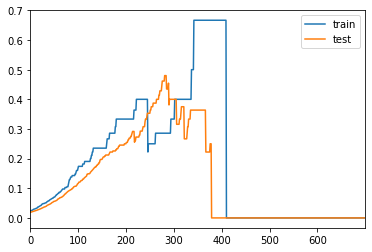

In [247]:
responses = []
trgts = df[:5000]
startIdx = 0
endIdx = 200

query = "Smoking tobacco"

while startIdx < len(trgts):
    #responses = responses + trgts[startIdx:endIdx].text.to_list()
    
    responses = responses + openai.Engine("davinci").search(documents=\
                trgts[startIdx:endIdx].text.to_list(), query=query)["data"]
    startIdx += 200
    endIdx += 200
    time.sleep(2)

trgts["seach_sim"] = [float(x["score"]) for x in responses]

cutoff_f1 = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1.at["f1", i] = f1_score(trgts.Tobacco[:1000], trgts.search_pos[:1000])

cutoff = cutoff_f1.T.idxmax()[0]
cutoff

cutoff_f1_test = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1_test.at["f1", i] = f1_score(trgts.Tobacco[1000:], trgts.search_pos[1000:])

ax = cutoff_f1.T.rename(columns={"f1":"train"}).plot()
cutoff_f1_test.T.rename(columns={"f1":"test"}).plot(ax=ax)
trgts.to_pickle("../{}.pkl".format(query))
cutoff_f1_test[cutoff]


/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata

f1    0.125
Name: 647, dtype: float64

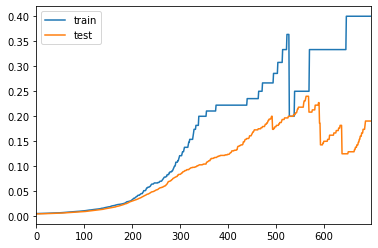

In [248]:
responses = []
trgts = df[:5000]
startIdx = 0
endIdx = 200

query = "Smoking"

while startIdx < len(trgts):
    #responses = responses + trgts[startIdx:endIdx].text.to_list()
    
    responses = responses + openai.Engine("davinci").search(documents=\
                trgts[startIdx:endIdx].text.to_list(), query=query)["data"]
    startIdx += 200
    endIdx += 200
    time.sleep(2)

trgts["seach_sim"] = [float(x["score"]) for x in responses]

cutoff_f1 = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1.at["f1", i] = f1_score(trgts.Tobacco[:1000], trgts.search_pos[:1000])

cutoff = cutoff_f1.T.idxmax()[0]
cutoff

cutoff_f1_test = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1_test.at["f1", i] = f1_score(trgts.Tobacco[1000:], trgts.search_pos[1000:])

ax = cutoff_f1.T.rename(columns={"f1":"train"}).plot()
cutoff_f1_test.T.rename(columns={"f1":"test"}).plot(ax=ax)
trgts.to_pickle("../{}.pkl".format(query))
cutoff_f1_test[cutoff]


/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata

f1    0.363636
Name: 99, dtype: float64

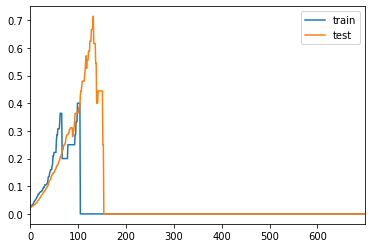

In [249]:
responses = []
trgts = df[:5000]
startIdx = 0
endIdx = 200

query = "This mentions tobacco."

while startIdx < len(trgts):
    #responses = responses + trgts[startIdx:endIdx].text.to_list()
    
    responses = responses + openai.Engine("davinci").search(documents=\
                trgts[startIdx:endIdx].text.to_list(), query=query)["data"]
    startIdx += 200
    endIdx += 200
    time.sleep(2)

trgts["seach_sim"] = [float(x["score"]) for x in responses]

cutoff_f1 = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1.at["f1", i] = f1_score(trgts.Tobacco[:1000], trgts.search_pos[:1000])

cutoff = cutoff_f1.T.idxmax()[0]
cutoff

cutoff_f1_test = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1_test.at["f1", i] = f1_score(trgts.Tobacco[1000:], trgts.search_pos[1000:])

ax = cutoff_f1.T.rename(columns={"f1":"train"}).plot()
cutoff_f1_test.T.rename(columns={"f1":"test"}).plot(ax=ax)
trgts.to_pickle("../{}.pkl".format(query))
cutoff_f1_test[cutoff]


/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata

f1    0.245614
Name: 450, dtype: float64

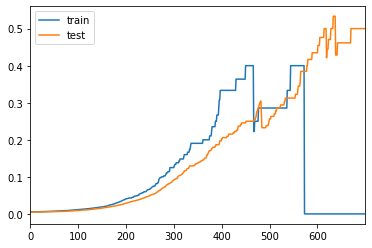

In [250]:
responses = []
trgts = df[:5000]
startIdx = 0
endIdx = 200

query = "cigarettes"

while startIdx < len(trgts):
    #responses = responses + trgts[startIdx:endIdx].text.to_list()
    
    responses = responses + openai.Engine("davinci").search(documents=\
                trgts[startIdx:endIdx].text.to_list(), query=query)["data"]
    startIdx += 200
    endIdx += 200
    time.sleep(2)

trgts["seach_sim"] = [float(x["score"]) for x in responses]

cutoff_f1 = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1.at["f1", i] = f1_score(trgts.Tobacco[:1000], trgts.search_pos[:1000])

cutoff = cutoff_f1.T.idxmax()[0]
cutoff

cutoff_f1_test = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1_test.at["f1", i] = f1_score(trgts.Tobacco[1000:], trgts.search_pos[1000:])

ax = cutoff_f1.T.rename(columns={"f1":"train"}).plot()
cutoff_f1_test.T.rename(columns={"f1":"test"}).plot(ax=ax)
trgts.to_pickle("../{}.pkl".format(query))
cutoff_f1_test[cutoff]


/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata

f1    0.197183
Name: 69, dtype: float64

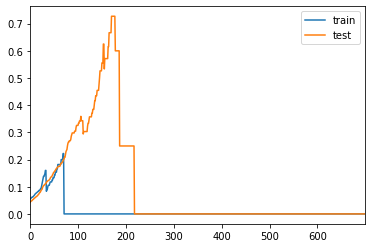

In [252]:
responses = []
trgts = df[:5000]
startIdx = 0
endIdx = 200

query = "mentions tobacco."

while startIdx < len(trgts):
    #responses = responses + trgts[startIdx:endIdx].text.to_list()
    
    responses = responses + openai.Engine("davinci").search(documents=\
                trgts[startIdx:endIdx].text.to_list(), query=query)["data"]
    startIdx += 200
    endIdx += 200
    time.sleep(2)

trgts["seach_sim"] = [float(x["score"]) for x in responses]

cutoff_f1 = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1.at["f1", i] = f1_score(trgts.Tobacco[:1000], trgts.search_pos[:1000])

cutoff = cutoff_f1.T.idxmax()[0]
cutoff

cutoff_f1_test = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1_test.at["f1", i] = f1_score(trgts.Tobacco[1000:], trgts.search_pos[1000:])

ax = cutoff_f1.T.rename(columns={"f1":"train"}).plot()
cutoff_f1_test.T.rename(columns={"f1":"test"}).plot(ax=ax)
trgts.to_pickle("../{}.pkl".format(query))
cutoff_f1_test[cutoff]


/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata

f1    0.255319
Name: 119, dtype: float64

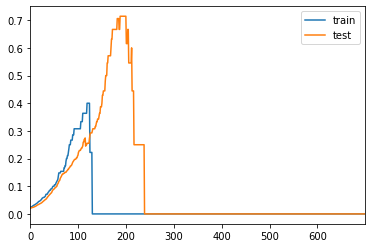

In [253]:
responses = []
trgts = df[:5000]
startIdx = 0
endIdx = 200

query = "mentioning tobacco."

while startIdx < len(trgts):
    #responses = responses + trgts[startIdx:endIdx].text.to_list()
    
    responses = responses + openai.Engine("davinci").search(documents=\
                trgts[startIdx:endIdx].text.to_list(), query=query)["data"]
    startIdx += 200
    endIdx += 200
    time.sleep(2)

trgts["seach_sim"] = [float(x["score"]) for x in responses]

cutoff_f1 = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1.at["f1", i] = f1_score(trgts.Tobacco[:1000], trgts.search_pos[:1000])

cutoff = cutoff_f1.T.idxmax()[0]
cutoff

cutoff_f1_test = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1_test.at["f1", i] = f1_score(trgts.Tobacco[1000:], trgts.search_pos[1000:])

ax = cutoff_f1.T.rename(columns={"f1":"train"}).plot()
cutoff_f1_test.T.rename(columns={"f1":"test"}).plot(ax=ax)
trgts.to_pickle("../{}.pkl".format(query))
cutoff_f1_test[cutoff]


/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata

f1    0.214286
Name: 134, dtype: float64

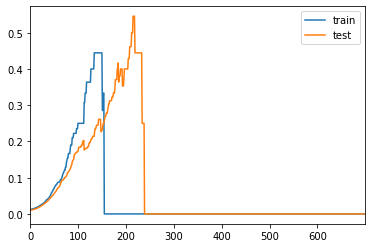

In [254]:
responses = []
trgts = df[:5000]
startIdx = 0
endIdx = 200

query = "referencing tobacco."

while startIdx < len(trgts):
    #responses = responses + trgts[startIdx:endIdx].text.to_list()
    
    responses = responses + openai.Engine("davinci").search(documents=\
                trgts[startIdx:endIdx].text.to_list(), query=query)["data"]
    startIdx += 200
    endIdx += 200
    time.sleep(2)

trgts["seach_sim"] = [float(x["score"]) for x in responses]

cutoff_f1 = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1.at["f1", i] = f1_score(trgts.Tobacco[:1000], trgts.search_pos[:1000])

cutoff = cutoff_f1.T.idxmax()[0]
cutoff

cutoff_f1_test = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1_test.at["f1", i] = f1_score(trgts.Tobacco[1000:], trgts.search_pos[1000:])

ax = cutoff_f1.T.rename(columns={"f1":"train"}).plot()
cutoff_f1_test.T.rename(columns={"f1":"test"}).plot(ax=ax)
trgts.to_pickle("../{}.pkl".format(query))
cutoff_f1_test[cutoff]


/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata

f1    0.434783
Name: 251, dtype: float64

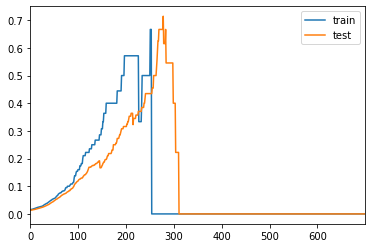

In [255]:
responses = []
trgts = df[:5000]
startIdx = 0
endIdx = 200

query = "referencing tobacco"

while startIdx < len(trgts):
    #responses = responses + trgts[startIdx:endIdx].text.to_list()
    
    responses = responses + openai.Engine("davinci").search(documents=\
                trgts[startIdx:endIdx].text.to_list(), query=query)["data"]
    startIdx += 200
    endIdx += 200
    time.sleep(2)

trgts["seach_sim"] = [float(x["score"]) for x in responses]

cutoff_f1 = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1.at["f1", i] = f1_score(trgts.Tobacco[:1000], trgts.search_pos[:1000])

cutoff = cutoff_f1.T.idxmax()[0]
cutoff

cutoff_f1_test = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1_test.at["f1", i] = f1_score(trgts.Tobacco[1000:], trgts.search_pos[1000:])

ax = cutoff_f1.T.rename(columns={"f1":"train"}).plot()
cutoff_f1_test.T.rename(columns={"f1":"test"}).plot(ax=ax)
trgts.to_pickle("../{}.pkl".format(query))
cutoff_f1_test[cutoff]


/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata

f1    0.272727
Name: 85, dtype: float64

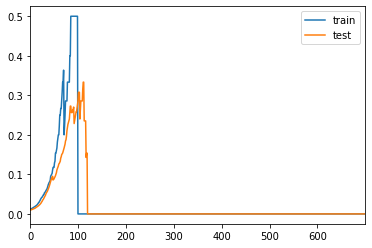

In [251]:
responses = []
trgts = df[:5000]
startIdx = 0
endIdx = 200

query = "cigarettes, dip, or cigars"

while startIdx < len(trgts):
    #responses = responses + trgts[startIdx:endIdx].text.to_list()
    
    responses = responses + openai.Engine("davinci").search(documents=\
                trgts[startIdx:endIdx].text.to_list(), query=query)["data"]
    startIdx += 200
    endIdx += 200
    time.sleep(2)

trgts["seach_sim"] = [float(x["score"]) for x in responses]

cutoff_f1 = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1.at["f1", i] = f1_score(trgts.Tobacco[:1000], trgts.search_pos[:1000])

cutoff = cutoff_f1.T.idxmax()[0]
cutoff

cutoff_f1_test = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1_test.at["f1", i] = f1_score(trgts.Tobacco[1000:], trgts.search_pos[1000:])

ax = cutoff_f1.T.rename(columns={"f1":"train"}).plot()
cutoff_f1_test.T.rename(columns={"f1":"test"}).plot(ax=ax)
trgts.to_pickle("../{}.pkl".format(query))
cutoff_f1_test[cutoff]


/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata

f1    0.001042
Name: 0, dtype: float64

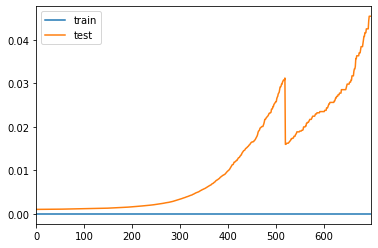

In [243]:
responses = []
trgts = df[:5000]
startIdx = 0
endIdx = 200

query = "Vaping"

while startIdx < len(trgts):
    #responses = responses + trgts[startIdx:endIdx].text.to_list()
    
    responses = responses + openai.Engine("davinci").search(documents=\
                trgts[startIdx:endIdx].text.to_list(), query=query)["data"]
    startIdx += 200
    endIdx += 200
    time.sleep(2)

trgts["seach_sim"] = [float(x["score"]) for x in responses]

cutoff_f1 = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1.at["f1", i] = f1_score(trgts.Vaping[:1000], trgts.search_pos[:1000])

cutoff = cutoff_f1.T.idxmax()[0]
cutoff

cutoff_f1_test = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1_test.at["f1", i] = f1_score(trgts.Vaping[1000:], trgts.search_pos[1000:])

ax = cutoff_f1.T.rename(columns={"f1":"train"}).plot()
cutoff_f1_test.T.rename(columns={"f1":"test"}).plot(ax=ax)

trgts.to_pickle("../{}.pkl".format(query))
cutoff_f1_test[cutoff]


/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata

f1    0.780083
Name: 376, dtype: float64

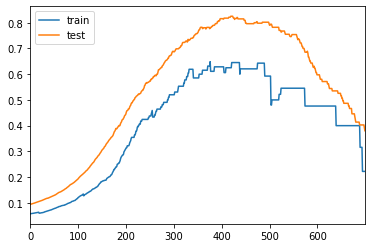

In [244]:
responses = []
trgts = df[:5000]
startIdx = 0
endIdx = 200

query = "Marijuana"

while startIdx < len(trgts):
    #responses = responses + trgts[startIdx:endIdx].text.to_list()
    
    responses = responses + openai.Engine("davinci").search(documents=\
                trgts[startIdx:endIdx].text.to_list(), query=query)["data"]
    startIdx += 200
    endIdx += 200
    time.sleep(2)

trgts["seach_sim"] = [float(x["score"]) for x in responses]

cutoff_f1 = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1.at["f1", i] = f1_score(trgts.Marijuana[:1000], trgts.search_pos[:1000])

cutoff = cutoff_f1.T.idxmax()[0]
cutoff

cutoff_f1_test = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1_test.at["f1", i] = f1_score(trgts.Marijuana[1000:], trgts.search_pos[1000:])

ax = cutoff_f1.T.rename(columns={"f1":"train"}).plot()
cutoff_f1_test.T.rename(columns={"f1":"test"}).plot(ax=ax)

trgts.to_pickle("../{}.pkl".format(query))
cutoff_f1_test[cutoff]


/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata

f1    0.262295
Name: 300, dtype: float64

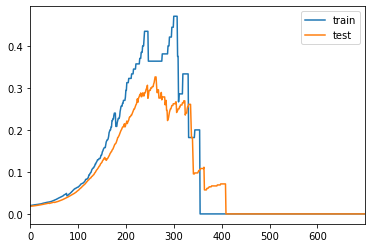

In [245]:
responses = []
trgts = df[:5000]
startIdx = 0
endIdx = 200

query = "Illegal drugs"

while startIdx < len(trgts):
    #responses = responses + trgts[startIdx:endIdx].text.to_list()
    
    responses = responses + openai.Engine("davinci").search(documents=\
                trgts[startIdx:endIdx].text.to_list(), query=query)["data"]
    startIdx += 200
    endIdx += 200
    time.sleep(2)

trgts["seach_sim"] = [float(x["score"]) for x in responses]

cutoff_f1 = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1.at["f1", i] = f1_score(trgts["Illegal drugs"][:1000], trgts.search_pos[:1000])

cutoff = cutoff_f1.T.idxmax()[0]
cutoff

cutoff_f1_test = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1_test.at["f1", i] = f1_score(trgts["Illegal drugs"][1000:], trgts.search_pos[1000:])

ax = cutoff_f1.T.rename(columns={"f1":"train"}).plot()
cutoff_f1_test.T.rename(columns={"f1":"test"}).plot(ax=ax)

trgts.to_pickle("../{}.pkl".format(query))
cutoff_f1_test[cutoff]


/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata

f1    0.229508
Name: 112, dtype: float64

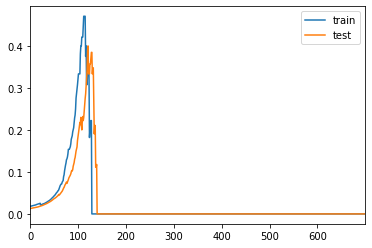

In [246]:
responses = []
trgts = df[:5000]
startIdx = 0
endIdx = 200

query = "Prescription drugs"

while startIdx < len(trgts):
    #responses = responses + trgts[startIdx:endIdx].text.to_list()
    
    responses = responses + openai.Engine("davinci").search(documents=\
                trgts[startIdx:endIdx].text.to_list(), query=query)["data"]
    startIdx += 200
    endIdx += 200
    time.sleep(2)

trgts["seach_sim"] = [float(x["score"]) for x in responses]

cutoff_f1 = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1.at["f1", i] = f1_score(trgts["Prescription drugs"][:1000], trgts.search_pos[:1000])

cutoff = cutoff_f1.T.idxmax()[0]
cutoff

cutoff_f1_test = pd.DataFrame()
for i in range(0, 700):
    trgts["search_pos"] = trgts["seach_sim"].apply(lambda x: 1 if x > i else 0)
    cutoff_f1_test.at["f1", i] = f1_score(trgts["Prescription drugs"][1000:], trgts.search_pos[1000:])

ax = cutoff_f1.T.rename(columns={"f1":"train"}).plot()
cutoff_f1_test.T.rename(columns={"f1":"test"}).plot(ax=ax)

trgts.to_pickle("../{}.pkl".format(query))
cutoff_f1_test[cutoff]
